In [1]:
# import necessary libraries
import pandas as pd
import numpy as np

# basic text cleaning
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

# feature engineering - tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble  import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

# data visualization plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sentiment analysis VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Loading the data

In [2]:
# load the two datasets into a Pandas DataFrame
df1 = pd.read_csv('exais_sms.csv')
df2 = pd.read_csv('nus_sms.csv', encoding='ISO-8859-1')

### Brief view of df1

In [3]:
# print df1
df1

,Status,Spam,Message
0,receive,1,Dear Customer as a G-BAM customer you have r...
1,receive,1,Dear Customer as a G-BAM customer you have r...
2,receive,1,Want to win a Walker? Click here www.Facebook....
3,receive,1,Want to win a Walker? Click here www.Facebook....
4,receive,1,GREAT NEWS!We celebrate Nigeria's 100 years &w...
...,...,...,...
4976,receive,1,Laugh till you drop with rib cracking hilario...
4977,receive,1,Discover the secrets to adding romance to your...
4978,receive,1,"Keep gum or Tic Tacs in your purse. ""Want one?..."
4979,receive,1,A funny joke is the the best way to bring smil...


There are a total of 4,981 messages.
- **Status**: Indicates whether the SMS message was received or sent. It helps to distinguish the direction of the communication.
- **Spam**: Signifies whether the SMS message is classified as spam (1) or ham (0).
- **Message**: Contains the actual text of the SMS message.

### Brief view of df2

In [4]:
# print df2
df2

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


There are a total of 5,572 messages.
- **v1**: Signifies whether the SMS message is classified as spam or ham.
- **v2**: Contains the actual text of the SMS message.
- **Unnamed:2, 3 and 4**: These columns do not contain relevant information and do not contribute to the analysis.

## Data Preprocessing for df1

In [5]:
# drop 'Status' columns
df1 = df1.drop('Status', axis=1)

# rename the other two columns for clarity
df1.columns = ['label', 'text']

#print the dataset
df1

,label,text
0,1,Dear Customer as a G-BAM customer you have r...
1,1,Dear Customer as a G-BAM customer you have r...
2,1,Want to win a Walker? Click here www.Facebook....
3,1,Want to win a Walker? Click here www.Facebook....
4,1,GREAT NEWS!We celebrate Nigeria's 100 years &w...
...,...,...
4976,1,Laugh till you drop with rib cracking hilario...
4977,1,Discover the secrets to adding romance to your...
4978,1,"Keep gum or Tic Tacs in your purse. ""Want one?..."
4979,1,A funny joke is the the best way to bring smil...


## Data Preprocessing for df2

In [6]:
# drop 'Unnamed' columns
df2 = df2.dropna(how="any", axis=1)

# rename v1 and v2 columns for clarity
df2.columns = ['label', 'text']

#print first 5 rows of the dataset
df2.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


To ensure consistency between the **label** in df1 and df2, I will encode the label for df2 so that they match in format.

In [7]:
label_mapping = {'ham': 0, 'spam': 1}
df2.loc[:, 'label'] = df2['label'].map(label_mapping)

#print first 5 rows of the dataset
df2.head()

C:\Users\lisaa\AppData\Local\Temp\ipykernel_25428\3953577375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'label'] = df2['label'].map(label_mapping)
C:\Users\lisaa\AppData\Local\Temp\ipykernel_25428\3953577375.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df2.loc[:, 'label'] = df2['label'].map(label_mapping)


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Combine df1 and df2

I will now combine both dataset and save to a new CSV file.

In [8]:
# Combine the DataFrames
combined_df = pd.concat([df1, df2], ignore_index=True)

# Save to a new CSV file
combined_df.to_csv('combined_file.csv', index=False)

# Load the new dataset

From this point, I will be loading and using the new dataset for the project.

In [9]:
# load the dataset into a Pandas DataFrame
df = pd.read_csv('combined_file.csv')

# print the dataset
df

,label,text
0,1,Dear Customer as a G-BAM customer you have r...
1,1,Dear Customer as a G-BAM customer you have r...
2,1,Want to win a Walker? Click here www.Facebook....
3,1,Want to win a Walker? Click here www.Facebook....
4,1,GREAT NEWS!We celebrate Nigeria's 100 years &w...
...,...,...
10548,1,This is the 2nd time we have tried 2 contact u...
10549,0,Will Ì_ b going to esplanade fr home?
10550,0,"Pity, * was in mood for that. So...any other s..."
10551,0,The guy did some bitching but I acted like i'd...


## Data Exploration

In [10]:
# understand the size and dimensions
df.shape

(10553, 2)

In [11]:
# gain insight into the distribution and range of numeric data
df.describe()

,label
count,10553.000000
mean,0.276983
std,0.447529
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [12]:
# check data types and overall structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10553 entries, 0 to 10552
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10553 non-null  int64 
 1   text    10553 non-null  object
dtypes: int64(1), object(1)
memory usage: 165.0+ KB


In [13]:
# check for any missing values
df.isnull().sum()

label    0
text     0
dtype: int64

In [14]:
# check for any duplicate entries
checkforduplicates = df[df.duplicated()]
checkforduplicates

,label,text
1,1,Dear Customer as a G-BAM customer you have r...
3,1,Want to win a Walker? Click here www.Facebook....
10,0,Acct name adejola Afeez olakunle. acct number ...
43,1,Are you a graduate or professional looking for...
44,1,Looking for a new job?A good CV should be shor...
...,...,...
10505,1,You are awarded a SiPix Digital Camera! call 0...
10516,0,"I know you are thinkin malaria. But relax, chi..."
10520,0,Just sleeping..and surfing
10534,0,Hahaha..use your brain dear


There are 1,560 duplicated rows in my dataset. Therefore, I will drop them to avoid biases and ensure that my model learns from diverse examples.

In [15]:
# drop duplicate entries
data = df.drop_duplicates()
data

,label,text
0,1,Dear Customer as a G-BAM customer you have r...
2,1,Want to win a Walker? Click here www.Facebook....
4,1,GREAT NEWS!We celebrate Nigeria's 100 years &w...
5,1,Enjoy uninterrupted chatting and PINGing on BB...
6,1,Y'ello! Get fast easy reliable and unlimited...
...,...,...
10548,1,This is the 2nd time we have tried 2 contact u...
10549,0,Will Ì_ b going to esplanade fr home?
10550,0,"Pity, * was in mood for that. So...any other s..."
10551,0,The guy did some bitching but I acted like i'd...


## Text Cleaning

In [16]:
# initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [17]:
def get_wordnet_pos(treebank_tag):
    """Convert treebank tag to wordnet tag."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [18]:
def preprocess_text(text):
    # convert text to lowercase
    text = text.lower()
    
    # tokenize the text
    tokens = word_tokenize(text)
    
    # POS tagging
    tagged_tokens = pos_tag(tokens)
    
    # lemmatize and filter out non-alphanumeric tokens
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens if word.isalnum()]
    
    # remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # join tokens back into a single string
    return ' '.join(tokens)

- **Stopwords** are common words (e.g. and, the, is) that are typically removed as they do not carry significant meaning
- **Lemmatization** reduces words to their base or root form (e.g. 'eating' to 'eat')
    - **POS Tagging**: pos_tag(tokens) assigns part-of-speech tags to each token, helping the lemmatizer understand the context.
    - **Contextual Lemmatization**: The function get_wordnet_pos converts the Treebank POS tags to WordNet tags to assist in accurate lemmatization.
- **Lowercasing** ensures informity in text processing
- **Tokenization** breaks down a text into smaller units called 'tokens' that prepares text data for further analysis

By doing these, it helps in extracting features and reducing the dimensionality of the dataset.

In [19]:
# example 1 to show the function
ex1 = data.iloc[0]['text']
print(ex1)

Dear Customer  as a G-BAM customer  you have received FREE 5Mb for browsing. Browse and enjoy the best calling rates on G-Bam. Enjoy!


In [20]:
ex1cleantext = preprocess_text(ex1)
print(ex1cleantext)

dear customer customer receive free 5mb browse browse enjoy best call rate enjoy


In [21]:
# pre-process data
data['text_clean'] = data['text'].apply(preprocess_text)

# display the data with cleaned texts
data

C:\Users\lisaa\AppData\Local\Temp\ipykernel_25428\4178925156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_clean'] = data['text'].apply(preprocess_text)


,label,text,text_clean
0,1,Dear Customer as a G-BAM customer you have r...,dear customer customer receive free 5mb browse...
2,1,Want to win a Walker? Click here www.Facebook....,want win walker click like gotv facebook page ...
4,1,GREAT NEWS!We celebrate Nigeria's 100 years &w...,great news celebrate nigeria 100 year give awa...
5,1,Enjoy uninterrupted chatting and PINGing on BB...,enjoy uninterrupted chatting ping bbm n100 wee...
6,1,Y'ello! Get fast easy reliable and unlimited...,get fast easy reliable unlimited wifi access h...
...,...,...,...
10548,1,This is the 2nd time we have tried 2 contact u...,2nd time try 2 contact u win pound prize 2 cla...
10549,0,Will Ì_ b going to esplanade fr home?,b go esplanade fr home
10550,0,"Pity, * was in mood for that. So...any other s...",pity mood suggestion
10551,0,The guy did some bitching but I acted like i'd...,guy bitching act like interested buy something...


## Sentiment Analysis - VADER

In [22]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [23]:
# Define a function to extract sentiment features
def extract_sentiment_features(text):
    sentiment_scores = sia.polarity_scores(text)
    return {
        'sentiment': 'negative' if sentiment_scores['compound'] < 0
        else ('positive' if sentiment_scores['compound'] > 0
        else 'neutral'),
        'negative': sentiment_scores['neg'],
        'neutral': sentiment_scores['neu'],
        'positive': sentiment_scores['pos'],
        'compound': sentiment_scores['compound']
    }

The sentiment scores are calculated using the VaderSentiment library, which assigns scores to text based on the intensity of the sentiment expressed. 

Here's a breakdown of the sentiment scores used in the code:
- **negative**: Represents the intensity of negative sentiment in the text, ranging from 0 (no negative sentiment) to 1 (very negative sentiment).
- **neutral**: Represents the intensity of neutral sentiment in the text, ranging from 0 (no neutral sentiment) to 1 (very neutral sentiment).
- **positive**:Represents the intensity of positive sentiment in the text, ranging from 0 (no positive sentiment) to 1 (very positive sentiment).
- **compound**: Combines the intensity of all three sentiments (negative, neutral, and positive) into a single value, ranging from -1 (very negative) to 1 (very positive).

These scores can be used to determine the overall sentiment of a piece of text, with higher scores indicating stronger sentiment. By incorporating these scores into a spam detection model, it can improve the model's ability to detect messages with emotional or manipulative language.

In [24]:
# Apply the function to the 'cleaned_text' column
data_sentiment = data['text_clean'].apply(extract_sentiment_features).apply(pd.Series)

In [25]:
# Concatenate the original DataFrame with the sentiment features
data = pd.concat([data, data_sentiment], axis = 1)

# Display the dataset with sentiment scores
data

,label,text,text_clean,sentiment,negative,neutral,positive,compound
0,1,Dear Customer as a G-BAM customer you have r...,dear customer customer receive free 5mb browse...,positive,0.000,0.327,0.673,0.9477
2,1,Want to win a Walker? Click here www.Facebook....,want win walker click like gotv facebook page ...,positive,0.000,0.513,0.487,0.8860
4,1,GREAT NEWS!We celebrate Nigeria's 100 years &w...,great news celebrate nigeria 100 year give awa...,positive,0.000,0.564,0.436,0.9118
5,1,Enjoy uninterrupted chatting and PINGing on BB...,enjoy uninterrupted chatting ping bbm n100 wee...,positive,0.000,0.758,0.242,0.4939
6,1,Y'ello! Get fast easy reliable and unlimited...,get fast easy reliable unlimited wifi access h...,positive,0.000,0.847,0.153,0.4404
...,...,...,...,...,...,...,...,...
10548,1,This is the 2nd time we have tried 2 contact u...,2nd time try 2 contact u win pound prize 2 cla...,positive,0.000,0.545,0.455,0.8750
10549,0,Will Ì_ b going to esplanade fr home?,b go esplanade fr home,neutral,0.000,1.000,0.000,0.0000
10550,0,"Pity, * was in mood for that. So...any other s...",pity mood suggestion,negative,0.524,0.476,0.000,-0.2960
10551,0,The guy did some bitching but I acted like i'd...,guy bitching act like interested buy something...,positive,0.113,0.430,0.457,0.7506


In [26]:
data.groupby('label')['sentiment'].value_counts()

label  sentiment
0      positive     3650
       neutral      2341
       negative      900
1      positive     1551
       neutral       304
       negative      247
Name: sentiment, dtype: int64

For **{0: HAM}**, the SIA has counted that there are:
- 3,650 positive text messages
- 2,341 neutral text messages
- 900 negative text messages

It is evident that the ham messages are generally well-received and tend to convey favorable sentiments. The high count of positive messages compared to the negative ones indicates that positive sentiments are dominant in this category, while negative sentiments are less prevalent but still present.

For **{1: SPAM}**, the SIA has counted that there are:
- 1,551 positive text messages
- 304 neutral text messages
- 247 negative text messages

It is evident that the spam messages have a higher proportion of positive sentiment compared to negative sentiment. This means that spam contents can actually be more polarizing and impactful, often eliciting stronger emotional responses.

## Feature Extraction 1 - Using TF-IDF

In [27]:
# convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text_clean'])
X = hstack([X, data[['compound']].values])

# prepare labels
y = data['label']

### Model Training and Evaluation

In [28]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# prints the number of samples in the training and testing sets
print(X_train.shape[0], y_train.shape[0])
print(X_test.shape[0], y_test.shape[0])

6295 6295
2698 2698


#### Model Evaluation Function

This function is designed to measure how well a spam detection system performs. It looks at two things:

- actual labels from the test data (true_labels)
- labels predicted by the system (predicted_labels)

It then calculates four main metrics: accuracy, precision, recall, and F1-score.

Accuracy defines how often the system is correct overall.
Precision focuses on how many of the predicted 'spam' messages are actually spam out of all predicted 'spam' messages.
Recall shows the percentage of actual 'spam' messages that the system correctly identifies.
F1-score combines precision and recall to give a balanced view of the system's performance.
By focusing on these metrics for the 'spam' class (using pos_label='spam' in the calculations), the function helps to understand how well the system identifies spam in SMS messages. This is crucial for fine-tuning and improving spam detection models.

In [29]:
# function to evaluate model
def evaluate_statmodel(true_labels, predicted_labels):
    """
    Evaluate the performance of a binary classifier specifically for the 'spam' class.

    Parameters:
    - true_labels: True labels from the test set.
    - predicted_labels: Predicted labels from the classifier.

    Returns:
    - accuracy: Accuracy score of the classifier.
    - precision: Precision score for the 'spam' class.
    - recall: Recall score for the 'spam' class.
    - f1: F1-score for the 'spam' class.
    """
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, pos_label=1)  # Assuming 'spam' is positive class
    recall = recall_score(true_labels, predicted_labels, pos_label=1)
    f1 = f1_score(true_labels, predicted_labels, pos_label=1)
    
    return accuracy, precision, recall, f1

### Training TF-IDF on SVM, Decision Tree, Random Forest and XGBoost Model

In [30]:
# initialize SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# train with TF-IDF
svm_model.fit(X_train, y_train)

# predictions
y_pred_svm = svm_model.predict(X_test)

# compute evaluation metrics for SVM model
svm_metrics = evaluate_statmodel(y_test, y_pred_svm)

In [31]:
# initialize DT
dt_model = DecisionTreeClassifier(random_state=42)

# train with TF-IDF
dt_model.fit(X_train, y_train)

# predictions
y_pred_dt = dt_model.predict(X_test)

# compute evaluation metrics for DT model
dt_metrics = evaluate_statmodel(y_test, y_pred_dt)

In [32]:
# initialize RF
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# train with TF-IDF
rf_model.fit(X_train, y_train)

# predictions
y_pred_rf = rf_model.predict(X_test)

# compute evaluation metrics for RF model
rf_metrics = evaluate_statmodel(y_test, y_pred_rf)

In [33]:
# initialize XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)

# train with TF-IDF
xgb_model.fit(X_train, y_train)

# predictions
y_pred_xgb = xgb_model.predict(X_test)

# compute evaluation metrics for XGBoost model
xgb_metrics = evaluate_statmodel(y_test, y_pred_xgb)

### Print the results for the 4 models

In [34]:
print("Results:")
print("-------------------------------------")
print("SVM Model Metrics:")
print(f"Accuracy: {svm_metrics[0]*100:.2f}%")
print(f"Precision: {svm_metrics[1]*100:.2f}%")
print(f"Recall: {svm_metrics[2]*100:.2f}%")
print(f"F1 Score: {svm_metrics[3]*100:.2f}%")
print("-------------------------------------")
print("Decision Tree Model Metrics:")
print(f"Accuracy: {dt_metrics[0]*100:.2f}%")
print(f"Precision: {dt_metrics[1]*100:.2f}%")
print(f"Recall: {dt_metrics[2]*100:.2f}%")
print(f"F1 Score: {dt_metrics[3]*100:.2f}%")
print("-------------------------------------")
print("Random Forest Model Metrics:")
print(f"Accuracy: {rf_metrics[0]*100:.2f}%")
print(f"Precision: {rf_metrics[1]*100:.2f}%")
print(f"Recall: {rf_metrics[2]*100:.2f}%")
print(f"F1 Score: {rf_metrics[3]*100:.2f}%")
print("-------------------------------------")
print("XGBoost Model Metrics:")
print(f"Accuracy: {xgb_metrics[0]*100:.2f}%")
print(f"Precision: {xgb_metrics[1]*100:.2f}%")
print(f"Recall: {xgb_metrics[2]*100:.2f}%")
print(f"F1 Score: {xgb_metrics[3]*100:.2f}%")

Results:
-------------------------------------
SVM Model Metrics:
Accuracy: 90.70%
Precision: 87.15%
Recall: 72.00%
F1 Score: 78.85%
-------------------------------------
Decision Tree Model Metrics:
Accuracy: 87.29%
Precision: 74.10%
Recall: 72.62%
F1 Score: 73.35%
-------------------------------------
Random Forest Model Metrics:
Accuracy: 90.66%
Precision: 90.61%
Recall: 68.31%
F1 Score: 77.89%
-------------------------------------
XGBoost Model Metrics:
Accuracy: 89.66%
Precision: 84.54%
Recall: 69.85%
F1 Score: 76.50%


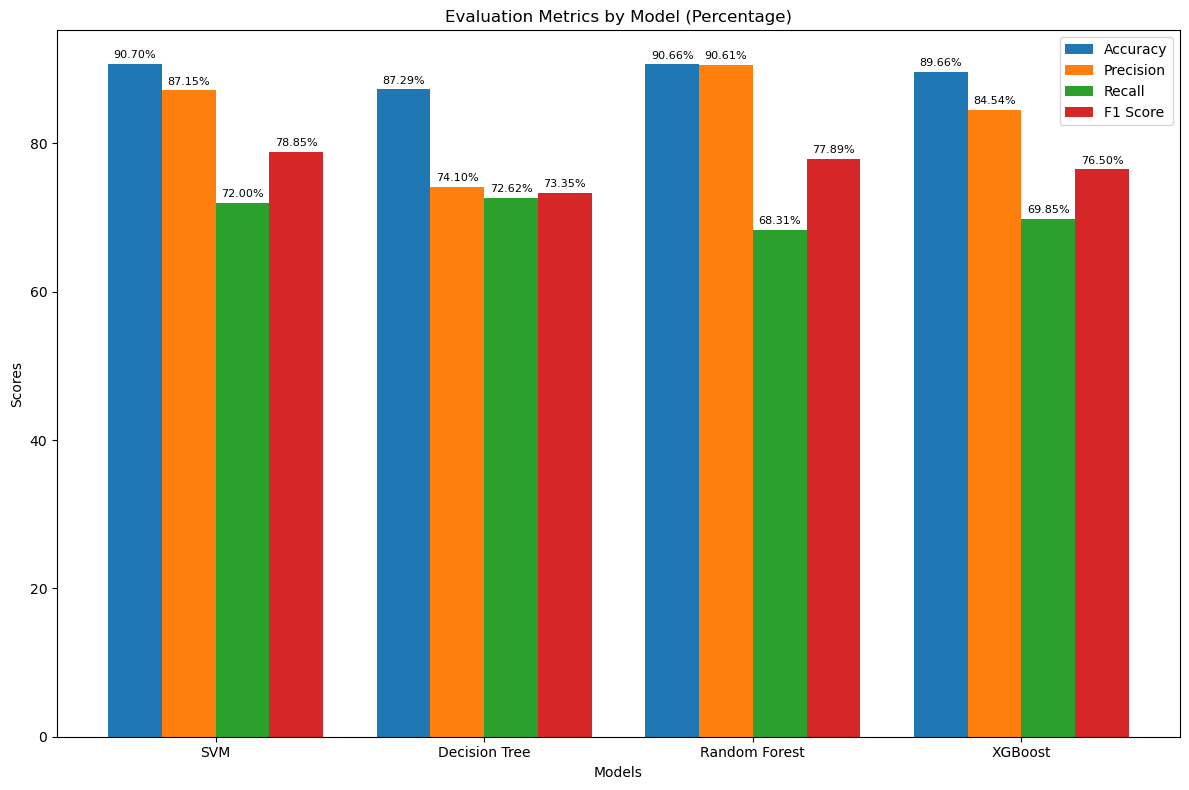

In [35]:
# define the models and their metrics
models = ['SVM', 'Decision Tree', 'Random Forest', 'XGBoost']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = {
    'SVM': svm_metrics,
    'Decision Tree': dt_metrics,
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics
}

# set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# plotting the metrics
bar_width = 0.2
index = np.arange(len(models))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, metric in enumerate(metrics):
    metric_scores = [scores[model][i] * 100 for model in models]
    ax.bar(index + i * bar_width, metric_scores, bar_width, label=metric, color=colors[i])
    # Adding text labels on top of each bar
    for j, score in enumerate(metric_scores):
        ax.text(index[j] + i * bar_width, score + 0.5, f'{score:.2f}%', ha='center', va='bottom', fontsize=8)

# adding labels, title, and customizing
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics by Model (Percentage)')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(models)
ax.legend()

# display the plot
plt.tight_layout()
plt.show()

### Interpretation and comparison using TF-IDF

1. **Accuracy: SVM > RF > XGB > DT**

SVM model has the highest accuracy (90.70%), closely followed by Random Forest and XGBoost. The Decision Tree model has the lowest accuracy among the four. Accuracy indicates how well the model classifies messages overall, but it doesn't account for class imbalance.

2. **Precision: RF > SVM > XGB > DT**

Random Forest has the highest precision (90.61%), meaning it has the lowest rate of false positives for the 'spam' class. SVM and XGBoost also perform well, but Decision Tree has significantly lower precision. Precision is crucial for evaluating how well the model avoids incorrectly labeling non-spam messages as spam.

3. **Recall: DT > SVM > XGB > RF**

Decision Tree model achieves the highest recall (72.62%), indicating it is the best at identifying actual spam messages. SVM and XGBoost are close behind, with Random Forest showing slightly lower recall. Recall is essential for understanding how many actual spam messages the model correctly identifies.

4. **F1 Score: SVM > RF > XGB > DT**

The SVM model leads in F1 Score (78.85%), which is a balanced measure combining precision and recall. Random Forest and XGBoost follow closely, with Decision Tree trailing. The F1 Score is a good overall measure of a model's performance, especially when you need a balance between precision and recall.

**Conclusion:**

In summary, SVM performs the best overall with top accuracy, F1-Score and high precision. It has a slightly lower recall compared to Decision Tree, but offers the most balanced performance.

## TF-IDF Hybrid Approach - Using Voting Classifier

In [36]:
# initialize VC
voting_clf = VotingClassifier(
    estimators=[
        ('SVM', svm_model),
        ('Decision Tree', dt_model),
        ('Random Forest', rf_model),
        ('XGBoost', xgb_model)
    ],
    # 'hard' for majority voting, 'soft' for probability-based voting
    voting='soft'
)

In [37]:
# train ith TF-IDF
voting_clf.fit(X_train, y_train)

# prediction
y_pred_voting = voting_clf.predict(X_test)

# compute evaluation metrics for VC model
voting_metrics = evaluate_statmodel(y_test, y_pred_voting)

### Print the results with Voting Classifier

In [38]:
print("Results:")
print("-------------------------------------")
print("Voting Classifier Model Metrics:")
print("----------------")
print("Hybrid Approach")
print("----------------")
print(f"Accuracy: {voting_metrics[0]*100:.2f}%")
print(f"Precision: {voting_metrics[1]*100:.2f}%")
print(f"Recall: {voting_metrics[2]*100:.2f}%")
print(f"F1 Score: {voting_metrics[3]*100:.2f}%")
print("-------------------------------------")
print("SVM Model Metrics:")
print(f"Accuracy: {svm_metrics[0]*100:.2f}%")
print(f"Precision: {svm_metrics[1]*100:.2f}%")
print(f"Recall: {svm_metrics[2]*100:.2f}%")
print(f"F1 Score: {svm_metrics[3]*100:.2f}%")
print("-------------------------------------")
print("Decision Tree Model Metrics:")
print(f"Accuracy: {dt_metrics[0]*100:.2f}%")
print(f"Precision: {dt_metrics[1]*100:.2f}%")
print(f"Recall: {dt_metrics[2]*100:.2f}%")
print(f"F1 Score: {dt_metrics[3]*100:.2f}%")
print("-------------------------------------")
print("Random Forest Model Metrics:")
print(f"Accuracy: {rf_metrics[0]*100:.2f}%")
print(f"Precision: {rf_metrics[1]*100:.2f}%")
print(f"Recall: {rf_metrics[2]*100:.2f}%")
print(f"F1 Score: {rf_metrics[3]*100:.2f}%")
print("-------------------------------------")
print("XGBoost Model Metrics:")
print(f"Accuracy: {xgb_metrics[0]*100:.2f}%")
print(f"Precision: {xgb_metrics[1]*100:.2f}%")
print(f"Recall: {xgb_metrics[2]*100:.2f}%")
print(f"F1 Score: {xgb_metrics[3]*100:.2f}%")

Results:
-------------------------------------
Voting Classifier Model Metrics:
----------------
Hybrid Approach
----------------
Accuracy: 90.73%
Precision: 85.21%
Recall: 74.46%
F1 Score: 79.47%
-------------------------------------
SVM Model Metrics:
Accuracy: 90.70%
Precision: 87.15%
Recall: 72.00%
F1 Score: 78.85%
-------------------------------------
Decision Tree Model Metrics:
Accuracy: 87.29%
Precision: 74.10%
Recall: 72.62%
F1 Score: 73.35%
-------------------------------------
Random Forest Model Metrics:
Accuracy: 90.66%
Precision: 90.61%
Recall: 68.31%
F1 Score: 77.89%
-------------------------------------
XGBoost Model Metrics:
Accuracy: 89.66%
Precision: 84.54%
Recall: 69.85%
F1 Score: 76.50%


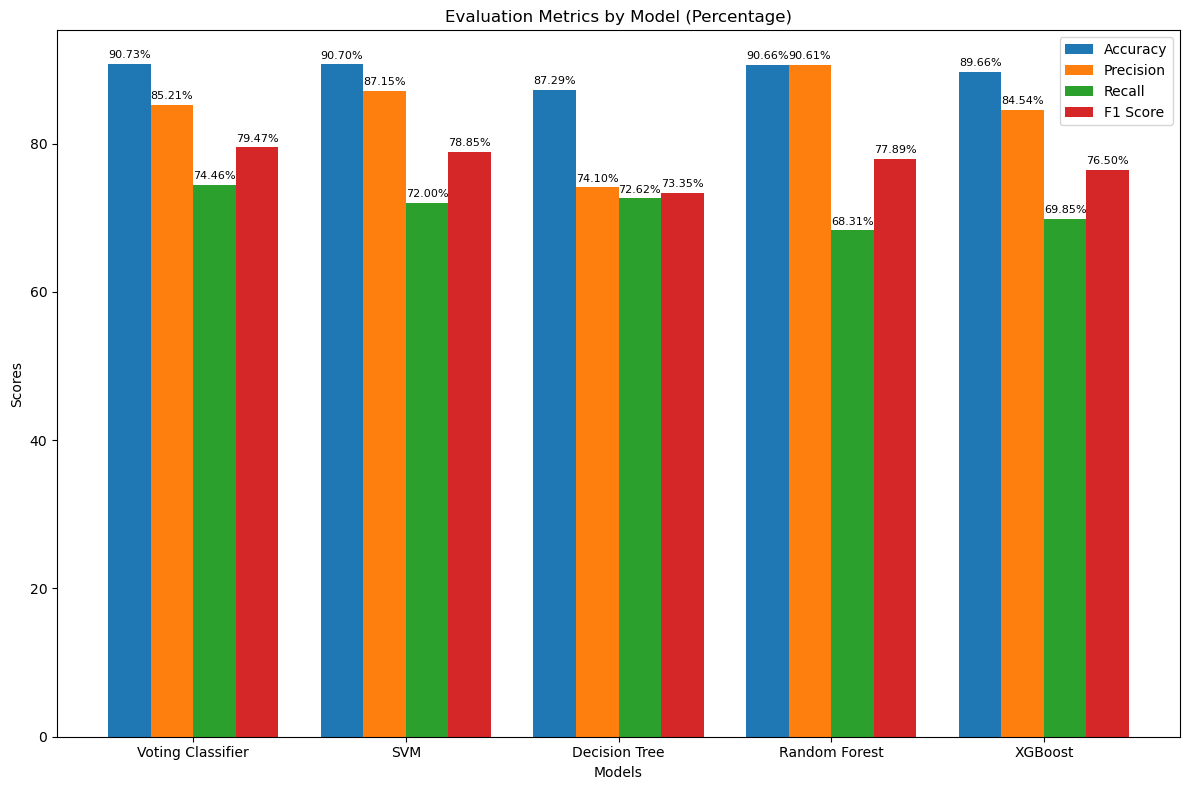

In [39]:
# define the models and their metrics
models = ['Voting Classifier', 'SVM', 'Decision Tree', 'Random Forest', 'XGBoost']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = {
    'Voting Classifier': voting_metrics,
    'SVM': svm_metrics,
    'Decision Tree': dt_metrics,
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics
}

# set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# plotting the metrics
bar_width = 0.2
index = np.arange(len(models))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, metric in enumerate(metrics):
    metric_scores = [scores[model][i] * 100 for model in models]
    ax.bar(index + i * bar_width, metric_scores, bar_width, label=metric, color=colors[i])
    # Adding text labels on top of each bar
    for j, score in enumerate(metric_scores):
        ax.text(index[j] + i * bar_width, score + 0.5, f'{score:.2f}%', ha='center', va='bottom', fontsize=8)

# adding labels, title, and customizing
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics by Model (Percentage)')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(models)
ax.legend()

# display the plot
plt.tight_layout()
plt.show()

## Feature Extraction 2 - Using Word2Vec